<a href="https://colab.research.google.com/github/13-1550/projNLP/blob/main/Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cyber Bullying Detection**

By Using GapHate Corpus we imported data of catigorized tweets to train the data:

-vo : violent language or context

-hd : hate speech

-cv : explicit calls to violence

In [ ]:
!pip install scikit-learn pandas

In [ ]:
!pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00
time: 395 µs (started: 2024-12-14 03:42:29 +00:00)


In [ ]:
import pandas as pd

time: 895 ms (started: 2024-12-14 03:42:29 +00:00)


In [ ]:
#dataset
train = pd.read_csv('ghc_train.tsv', sep='\t')
test = pd.read_csv('ghc_test.tsv', sep='\t')
test.sample(10)

,text,hd,cv,vo
1394,So then God is not infinitely knowing and wise?,0,0,0
2968,any E-drummer around?,0,0,0
3272,You're WIRED❗️ Did Omarosa break the law by se...,0,0,0
3143,think the American people need some very evil ...,0,0,0
1278,hahahaha! your humor is so believable.,0,0,0
3741,"No, No, No ..I WANT NAMES ❕❕❕",0,0,0
1948,Hitler didn’t start ww2. England declared war...,0,0,0
2685,Great Synopsis by Mark Dice...DEEP STATE/MSM/H...,0,0,0
4714,I swear this heat has made people crazier than...,0,0,0
4616,"tHE TIMES THEY ARE A CHANGIN, winning!!",0,0,0


time: 183 ms (started: 2024-12-14 03:42:30 +00:00)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics

Enhancing sentimental analysis

In [6]:

!pip install transformers torch
from transformers import pipeline

time: 30 s (started: 2024-12-14 03:42:41 +00:00)


In [7]:
pip install textblob

time: 3.62 s (started: 2024-12-14 03:43:11 +00:00)


In [9]:
from textblob import TextBlob

sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# get only negative sentiment
def filter_negative_sentiments(texts):
    results = sentiment_analyzer(texts)
    negative_texts = [text for text, result in zip(texts, results) if result['label'] == 'NEGATIVE']
    return negative_texts


# BERT sentiment analysis to filter for negative sentiments
train_negative_texts = filter_negative_sentiments(train['text'].tolist())
test_negative_texts = filter_negative_sentiments(test['text'].tolist())

# Update the training and test data to only include negative sentiment texts
train = train[train['text'].isin(train_negative_texts)]
test = test[test['text'].isin(test_negative_texts)]




time: 41min 30s (started: 2024-12-14 03:48:06 +00:00)


# **Preprocessing**

In [10]:
#removing URLS an special char
import re

def preprocess_text(text):

    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    return text

#preprocessing
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)



time: 157 ms (started: 2024-12-14 04:29:37 +00:00)


<ipython-input-10-5c1871b36105>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].apply(preprocess_text)
<ipython-input-10-5c1871b36105>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['text'] = test['text'].apply(preprocess_text)


In [11]:
!pip install nltk spacy gensim

time: 3.24 s (started: 2024-12-14 04:29:37 +00:00)


In [12]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec


train = pd.read_csv('ghc_train.tsv', sep='\t')
test = pd.read_csv('ghc_test.tsv', sep='\t')

nltk.download('punkt_tab')
nltk.download('stopwords')

# Preprocessing Pipeline
def preprocess_text(text):
    #  Tokenization
    tokens = word_tokenize(text)

    # normalization: Lowercasing and removing punctuation
    normalized = [re.sub(r'[^\w\s]', '', token.lower()) for token in tokens]

    #  removing stopwords
    filtered = [word for word in normalized if word not in stopwords.words('english') and word != '']

    # 4. Stemming
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in filtered]

    return stemmed

# Preprocessing
train['processed_text'] = train['text'].apply(preprocess_text)
test['processed_text'] = test['text'].apply(preprocess_text)

# Word2Vec
all_sentences = train['processed_text'].tolist() + test['processed_text'].tolist()
embedding_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)

train['embeddings'] = train['processed_text'].apply(lambda x: [embedding_model.wv[word] for word in x if word in embedding_model.wv])
test['embeddings'] = test['processed_text'].apply(lambda x: [embedding_model.wv[word] for word in x if word in embedding_model.wv])

# Example output
print(train[['text', 'processed_text', 'embeddings']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                text  \
0  He most likely converted to islam due to his n...   
1  So Ford lied about being a psychologist. Recor...   
2     Jobs. Education. Ending abuse of Nation. CA43.   
3  I share a lot of your values, & like many who ...   
4  I am so ready to get back to blogging! www.ben...   

                                      processed_text  \
0  [like, convert, islam, due, natur, suitabl, is...   
1  [ford, lie, psychologist, record, seem, indic,...   
2               [job, educ, end, abus, nation, ca43]   
3  [share, lot, valu, like, mani, nt, call, alt, ...   
4  [readi, get, back, blog, wwwbenbrihousecom, re...   

                                          embeddings  
0  [[-0.45503098, 0.70943093, 0.5025632, 0.064086...  
1  [[-0.121172994, 0.3215318, 0.24910592, 0.11978...  
2  [[-0.21044908, 0.5901213, 0.4308457, 0.1638194...  
3  [[-0.27743575, 0.49964428, 0.3596858, 0.103718...  
4  [[-0.15189637, 0.33469188, 0.24655932, 0.09847..

Urban dictionary API for better sentimental analysis to keep up with trendy words

In [13]:
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from textblob import TextBlob

#import the definitions from urban dictionary API
def get_urban_definition(word):
  try:
    url = f"https://api.urbandictionary.com/v0/define?term={word}"
    response = requests.get(url)

    if response.status_code == 200 and response.text.strip():
            result = response.json()  # Try parsing JSON response
            if result['list']:  # If there are definitions in the result
                return result['list'][0]['definition']  # Get the first definition
            else:
                return None  # Return None if no definition found
    else:
            print(f"Error: No data returned for word: {word}")
            return None
  except requests.exceptions.RequestException as e:
        # Catch any exceptions that occur during the request
        print(f"Request failed for word: {word}. Error: {e}")
        return None
  except ValueError as e:
        # Catch JSON decoding errors
        print(f"Error decoding JSON for word: {word}. Error: {e}")
        return None



time: 354 ms (started: 2024-12-14 04:31:58 +00:00)


In [14]:
def has_negative_sentiment(definition):
    blob = TextBlob(definition)
    return blob.sentiment.polarity < -0.5

# Preprocessing function that checks Urban Dictionary for offensive terms
def preprocess_and_flag(word_list):
    flagged_words = []
    # Preprocess words to clean punctuation
    cleaned_words = [re.sub(r"[^\w\s]", "", word)for word in word_list]

    # List of common words that should be skipped
    #During the testing of this program it was found that sometimes with ceritan examples it would count common words as flagged
    common_words = ["so", "the", "and", "a", "of", "to", "it", "is", "youre","an"]

  #applying concurrency to minimize runtime, (10) to avoid overhead
    with ThreadPoolExecutor(max_workers=10) as executor:
      definitions = list(executor.map(get_urban_definition, cleaned_words))

    for word, definition in zip(cleaned_words, definitions):
        if word.lower() in common_words:
            continue

        if definition and (
            'offensive' in definition.lower()
            or 'slang' in definition.lower()
            or has_negative_sentiment(definition)
        ):
            flagged_words.append(word)


    return flagged_words

#example output:
example =('such an annoying imbicle')
flagged_words_ex = preprocess_and_flag(example.split())

print('flagged_words:', flagged_words_ex)

#preprocessing training and test datasets
train['flagged_words'] = train['text'].apply(preprocess_and_flag)
test['flagged_words'] = test['text'].apply(preprocess_and_flag)

train = pd.read_csv('ghc_train.tsv', sep='\t')
test = pd.read_csv('ghc_test.tsv', sep='\t')



flagged_words: ['imbicle']
Error: No data returned for word: d
Error: No data returned for word: h
Error: No data returned for word: e
Error: No data returned for word: i
Error: No data returned for word: l
Error: No data returned for word: s
Error: No data returned for word: n
Error: No data returned for word: d
Request failed for word: f. Error: HTTPSConnectionPool(host='api.urbandictionary.com', port=443): Max retries exceeded with url: /v0/define?term=f (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_DECODE_ERROR] tlsv1 alert decode error (_ssl.c:1007)')))
Error: No data returned for word: s
Error: No data returned for word: l


KeyboardInterrupt: 

time: 7h 14min 14s (started: 2024-12-14 04:31:58 +00:00)


An example of flagged words
using
`print(f"Flagged Word: {word} - Definition: {definition}")`
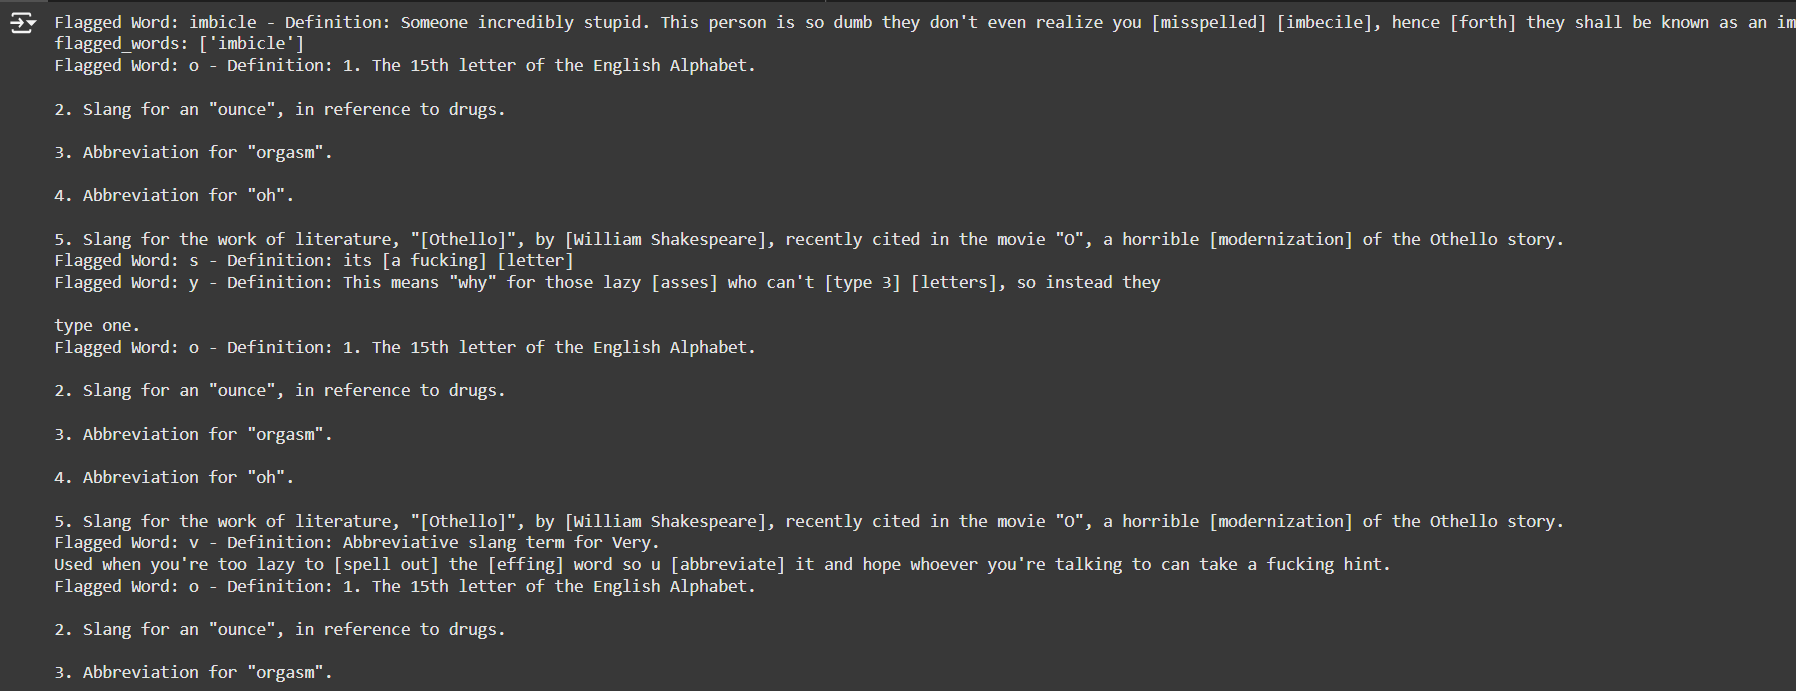
(Program was stopped and rerun without this line to avoid longer run time and preserve computational power)

`if response.status_code == 200 and response.text.strip():`
was used to make sure the API's response is valid and contains actual content before trying to process it

This API includes 1.9GB of Urban Dictionary definitions, in theory it would be great for training data but is costly regarding computational power.
++Due to limited RAM this code was unable to run, in theory these definitions would be inserted to the training data to better understand trendy words and slang.


# Vectorization


In [15]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer = TfidfVectorizer()
x_train_vec = vectorizer.fit_transform(train['text'])

x_train_vec = vectorizer.fit_transform(train['text'])
x_test_vec = vectorizer.transform(test['text'])


time: 1.52 s (started: 2024-12-14 11:46:18 +00:00)


# **Training the data**

using **distilbert**, a lighter and faster version of bert to perform sentiment analysis.

    return result[0]['label']

was used and not result[-1] because -1 doesnt guarntee all negative sentiments but only fully negative ones


---


for example:
"I  dislike ["certain eithnic group"]." would have a score of 0.98
[{'label': 'NEGATIVE', 'score': 0.98}]
which wouldn't be counted as a fully negative sentiment an wouldn't be included.

In [18]:
#selecting negative sentiments to train on
from textblob import TextBlob
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorization
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer = TfidfVectorizer()

x_train_vec = vectorizer.fit_transform(train['text'])
x_test_vec = vectorizer.transform(test['text'])


#target
y_train = train[['hd', 'vo', 'cv']]

# Model training
sgd_clf = MultiOutputClassifier(SGDClassifier())
sgd_clf.fit(x_train_vec, y_train)

# Predictions and evaluations
y_pred = sgd_clf.predict(x_test_vec)

time: 2.86 s (started: 2024-12-14 11:47:52 +00:00)


# Evaluting the data

for better evaluations, each category is evaluated separately

In [20]:
from sklearn.metrics import accuracy_score

def evaluate(model):
    y_pred = model.predict(x_test_vec)
    for i, col in enumerate(['hd', 'vo', 'cv']):
        accuracy = accuracy_score(test[col], y_pred[:, i])
        print(f'Accuracy for {col}: {100 * accuracy:.2f}%')

evaluate(sgd_clf)

Accuracy for hd: 91.23%
Accuracy for vo: 93.85%
Accuracy for cv: 99.56%
time: 25.3 ms (started: 2024-12-14 11:48:12 +00:00)


an example for evaluating them all together and the accuracy difference:

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}


grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(x_train_vec, train[['cv', 'hd', 'vo']])


best_rf = grid_search.best_estimator_
y_test = test[['cv', 'hd', 'vo']]

y_pred = best_rf.predict(x_test_vec)

overall_accuracy = accuracy_score(y_test, y_pred)

print(f"Overall Accuracy: {100 * overall_accuracy:.1f}%")



Overall Accuracy: 87.4%
time: 1h 5min 50s (started: 2024-12-14 18:33:37 +00:00)


Testing on another data set

In [34]:
import pickle

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the trained classifier
with open('sgd_clf.pkl', 'wb') as f:
    pickle.dump(sgd_clf, f)

time: 35 ms (started: 2024-12-14 19:45:50 +00:00)


In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

new_data = pd.read_csv('new_data.txt', sep='\t')

with open('new_data.txt', 'r') as file:
    lines = file.readlines()

new_data = pd.DataFrame({'text': [line.strip() for line in lines]})
print(new_data.head())

x_new = new_data['text']
vectorizer = TfidfVectorizer()

x_train_vec = vectorizer.fit_transform(train['text'])

x_new_vec = vectorizer.transform(x_new)


y_new_pred = best_rf.predict(x_new_vec)
y_new_pred_df = pd.DataFrame(y_new_pred, columns=['cv', 'hd', 'vo'])

#predictions
print("Predictions:")
print(y_new_pred_df)

# Evaluate
y_new_true = new_data[['cv', 'hd', 'vo']]

new_data.to_csv('predicted_data.csv', index=False)


from sklearn.metrics import classification_report
print("Evaluation Report:")
print(classification_report(y_new_true, y_new_pred_df, target_names=['cv', 'hd', 'vo']))


                                               text
0                "I hate people from that country."
1                "This group should be eradicated."
2      "We don’t need people like them in society."
3           "Anyone who believes that is an idiot."
4  "You don't belong here because of your beliefs."


NotFittedError: The TF-IDF vectorizer is not fitted

time: 527 ms (started: 2024-12-14 12:54:35 +00:00)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier
import pickle
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
#loaad vectorizer
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
#load classifier
with open('sgd_clf.pkl', 'rb') as f:
    sgd_clf = pickle.load(f)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
# Remove URLs =
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    text = re.sub(r'#\w+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text (split into words)
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words (reduce to their root form)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text


def process_text_input(text):

    text = preprocess_text(text)
    #get sentiment
    sentiment = sentiment_analyzer(text)
    sentiment_label = 1 if sentiment[0]['label'].upper() == 'NEGATIVE' else 0

    #TF-IDF
    vectorizer.fit([text])
    text_vec = vectorizer.transform([text]).toarray()
 #check the num of features matches the training feature space
    expected_features = sgd_clf.estimators_[0].coef_.shape[1]
    if text_vec.shape[1] != expected_features:
        print(f"Error: Feature mismatch! Got {text_vec.shape[1]} features, but model expects {expected_features} features.")
        return None

    #prediction
    prediction = sgd_clf.predict(text_vec)
    if prediction is None:
        print("Error: No prediction returned!")
        return None
    return prediction[0]

# User input and evaluation
def evaluate_user_input():
    print("Type a sentence to predict if it has any hate, violent speech, or bullying or type 'exit' to quit.")

    while True:
        user_input = input("Enter a sentence: ").strip()
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break

        try:
            prediction = process_text_input(user_input)
            if prediction is not None:
                print(f"Predicted values: \n hd={prediction[0]} \n vo={prediction[1]} \n cv={prediction[2]}")
            else:
                print("Error: No valid prediction could be made.")

        except Exception as e:
            print(f"Error in processing input: {e}")

#evaluation
evaluate_user_input()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Type a sentence to predict if it has any hate, violent speech, or bullying or type 'exit' to quit.
Enter a sentence: I think americans are evil people
Error: Feature mismatch! Got 4 features, but model expects 37154 features.
Error: No valid prediction could be made.
